In [50]:
import os
import sys
sys.path.append('..\..')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from set_global_params import processed_data_path
from bias_correlation_utils import categorise_da_responses, get_diff_in_proportion_correct, calculate_statistics, \
    calculate_psychometric, logistic
from utils.plotting_visuals import makes_plots_pretty, set_plotting_defaults
from utils.plotting import output_significance_stars_from_pval
import statsmodels.formula.api as smf


In [51]:
def plot_with_fitted_psychometric_curve(x, y, color=None, label=None, **kwargs):
    # Extract data from kwargs
    data = kwargs.pop("data")

    # Plotting the actual data
    sns.lineplot(x=x, y=y, data=data, label=label, color=color)

    # Getting logistic parameters for the mouse
    a, b = params_dict[data['mouse'].iloc[0]]

    # Generating the fitted curve values
    x_range = np.linspace(0, 1, 400)
    y_fit = logistic(x_range, a, b)

    # Plotting the fitted curve
    plt.plot(x_range, y_fit, color='red', linewidth=2)



In [52]:

# set some analysis parameters
quantile_cutoff = .65
slope_threshold = 1.  # slope at PSE of the psychometric function. this measures sensitivity
bias_threshold = .09  # bias of the behaviour during "easy" trials. this measures bias
# we include animals if they have a slope above the threshold AND a bias below the threshold


# Define colors for each data type
set_plotting_defaults(font_size=7)
colors = {'tail': ['#76A8DA', '#002F3A'], 'nacc': ['#F9C0AF', '#E95F32']}

coefficients_df = pd.DataFrame()
std_errors_df = pd.DataFrame()
p_vals = {}

# Set up data directory
data_dir = os.path.join(processed_data_path, 'psychometric_data')

file_paths = {'tail': os.path.join(data_dir, 'all_tail_data.csv'),
              'nacc': os.path.join(data_dir, 'nacc_data.csv')}

Analyzing site: tail
--------------------------------------------------
Excluding mice: ['SNL_photo37' 'SNL_photo70' 'SNL_photo72']


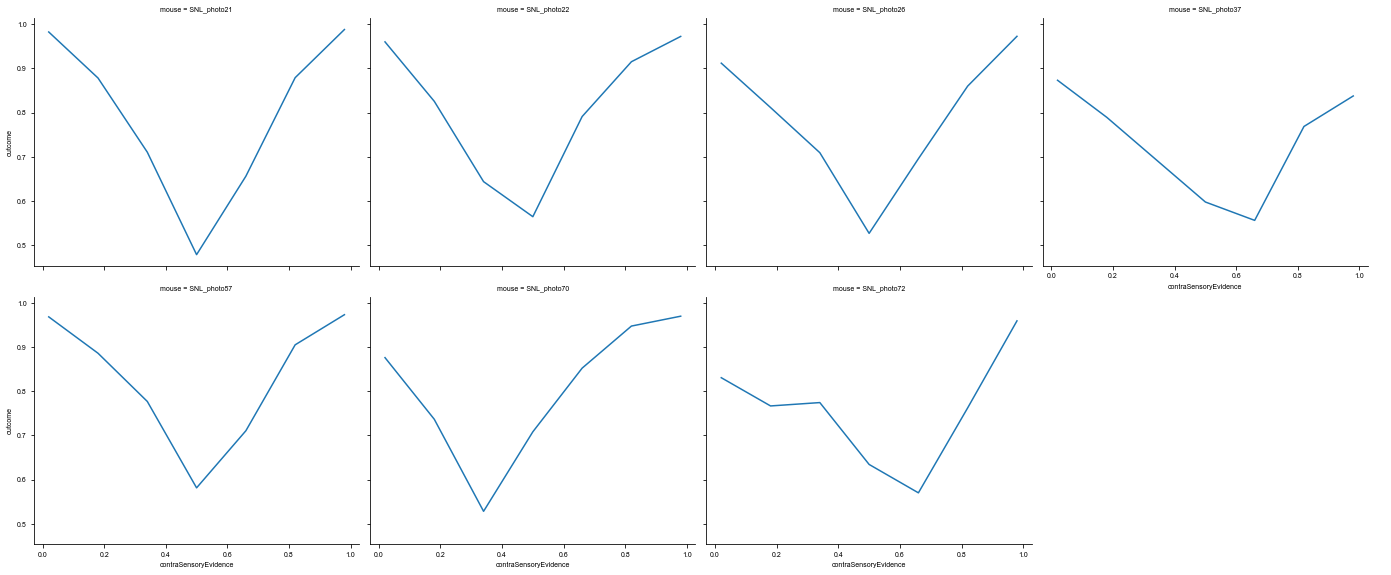

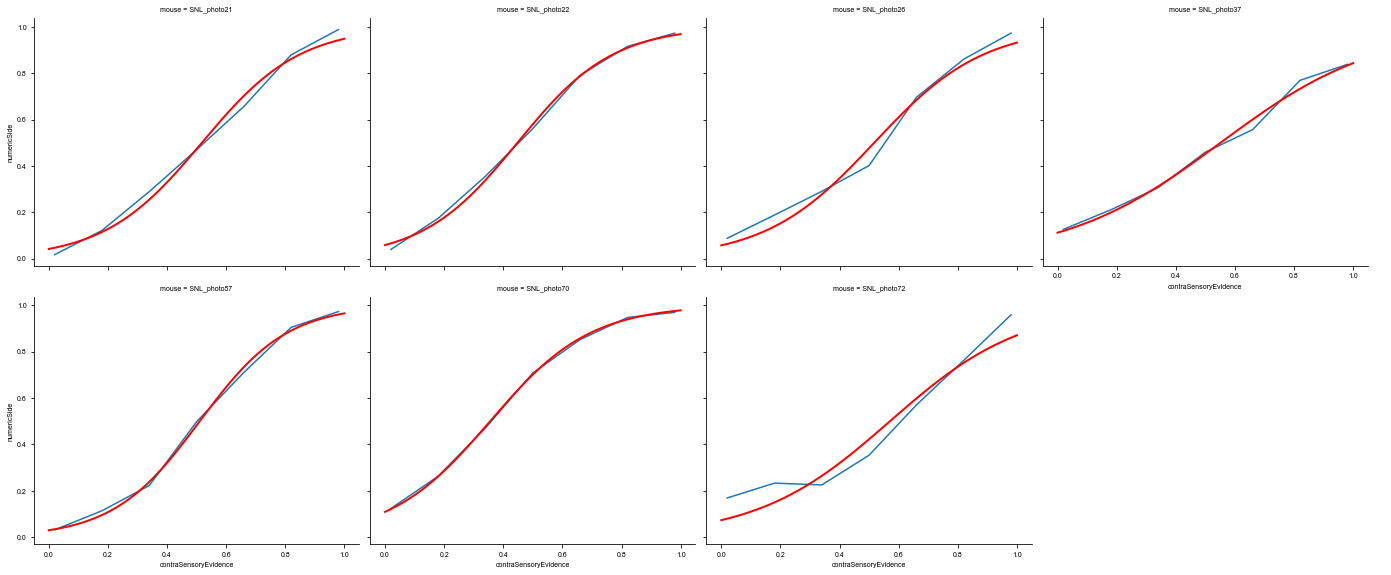

In [185]:
site = 'tail'
print('Analyzing site: {}'.format(site))
print('-' * 50)

file_path = file_paths[site]

# set up results directory
results_dir = os.path.join(data_dir, 'logistic_regression', 'results', site)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Load data
all_data = pd.read_csv(file_path)
df = all_data.copy()
df = calculate_statistics(df)

# ---------------------------------------------------------------
# calculate bias for each mouse
bias_df = get_diff_in_proportion_correct(df)
psymetric_df = calculate_psychometric(df)
psymetric_df.to_csv(os.path.join(results_dir, 'bias_df_{}.csv'.format(site)))

# ---------------------------------------------------------------
# show the average reward for each mouse as a function of uncertainty
# No need to filter only for correct trials here, we're including both correct and incorrect
grouped_by_mouse = df.groupby(['mouse', 'contraSensoryEvidence'])['outcome'].mean().reset_index()

# Create a line plot for each mouse
g = sns.FacetGrid(grouped_by_mouse, col="mouse", col_wrap=4, height=4, aspect=1.2)
g.map(sns.lineplot, 'contraSensoryEvidence', 'outcome')
g.add_legend()
plt.savefig(os.path.join(results_dir, 'outcome_vs_contraSensoryEvidence.png'))

# ---------------------------------------------------------------
# now show the choices for each mouse as a function of uncertainty

# No need to filter only for correct trials here, we're including both correct and incorrect
params_df = psymetric_df[['mouse', 'a', 'b']]

grouped_by_mouse = df.groupby(['mouse', 'contraSensoryEvidence'])['numericSide'].mean().reset_index()
params_dict = dict(zip(params_df['mouse'], params_df[['a', 'b']].values.tolist()))

# Create the FacetGrid
g = sns.FacetGrid(grouped_by_mouse, col="mouse", col_wrap=4, height=4, aspect=1.2)

# Mapping the modified plotting function to the FacetGrid
g.map_dataframe(plot_with_fitted_psychometric_curve, 'contraSensoryEvidence', 'numericSide')

g.add_legend()
plt.savefig(os.path.join(results_dir, 'choice_vs_contraSensoryEvidence_with_curve.png'))

# ---------------------------------------------------------------
# exclude incorrect trials and categorize DA response size
# Note, for the nacc the response is aligned to reward, so we can only use correct trials
# for the tail, the response is aligned to choice, so we use only correct trials where mice should have a bias,
# but all trials for the ambiguous stimulus (where incorrect / correct is not defined)
if site == 'tail':
    df = df[~((df['outcome'] == 0) & (df['contraSensoryEvidence'] != 0.5))]
    df = df.reset_index()
else:
    df = df[df['outcome'] == 1].reset_index(drop=True)

#df['DAresponseSize'] = df.groupby(['mouse'])['norm APE'].apply(categorise_da_responses,
#                                                               cutoff=quantile_cutoff).reset_index(drop=True)

# ---------------------------------------------------------------
# exclude mice with low slope and large bias
mice_to_exclude = []
for mouse in psymetric_df.mouse[psymetric_df.slope < slope_threshold]:
    mice_to_exclude.append(mouse)
for mouse in bias_df.mouse[bias_df.difference > bias_threshold]:
    mice_to_exclude.append(mouse)

print('Excluding mice: {}'.format(np.unique(mice_to_exclude)))
df = df[~df.mouse.isin(mice_to_exclude)]

In [73]:
df.columns

Index(['index', 'Unnamed: 0', 'mouse', 'session', 'fiber side',
       'trial numbers', 'trial type', 'side', 'outcome', 'last trial type',
       'last choice', 'last outcome', 'next trial type', 'next choice',
       'next outcome', 'norm APE', 'stay or switch', 'percentageHighTones',
       'contraSensoryEvidence', 'choiceSensoryEvidence', 'discriminatability',
       'numericSide', 'nextPercentageHighTones', 'nextContraSensoryEvidence',
       'nextDiscriminability', 'nextChoiceSensoryEvidence', 'nextNumericSide',
       'nextStaySwitch'],
      dtype='object')

In [205]:
import statsmodels.api as sm

# Resetting the index (if needed)
df = df.reset_index(drop=True).copy()
df['nextSideStay'] = (df['nextNumericSide'] == df['numericSide'])

# Loop over each unique value in the 'mouse' column
unique_mice = df['mouse'].unique()
# Create the new column 'staySensoryEvidence' with the transformation applied
df['nextStaySensoryEvidence'] = df['nextContraSensoryEvidence']

# Apply the transformation to the new column where df['numericSide'] == 0
df.loc[df['numericSide'] == 0, 'nextStaySensoryEvidence'] = 1 - df.loc[df['numericSide'] == 0, 'nextContraSensoryEvidence']

results = {}


for mouse in unique_mice:
    # Subset the data for the current mouse
    df_subset = df[df['mouse'] == mouse].copy()
    #df_subset = df_subset[df_subset['numericSide'] == 1]
    
    
    # Create the interaction term
    df_subset['Interaction'] = df_subset['norm APE'] * df_subset['nextContraSensoryEvidence']
    
    # Prepare the data for regression
    df_for_reg = df_subset[['norm APE', 'nextContraSensoryEvidence', 'Interaction', 'nextSideStay', 'nextNumericSide', 'numericSide']].copy()
    y = df_for_reg['nextNumericSide']
    X = sm.add_constant(df_for_reg[['nextContraSensoryEvidence', 'norm APE']])
    
    # Fit the logistic regression model
    logit_mod = sm.Logit(y, X)
    logit_res = logit_mod.fit(disp=0)  # Set disp=0 to suppress the output for each fit
    
    # Store the results
    results[mouse] = logit_res



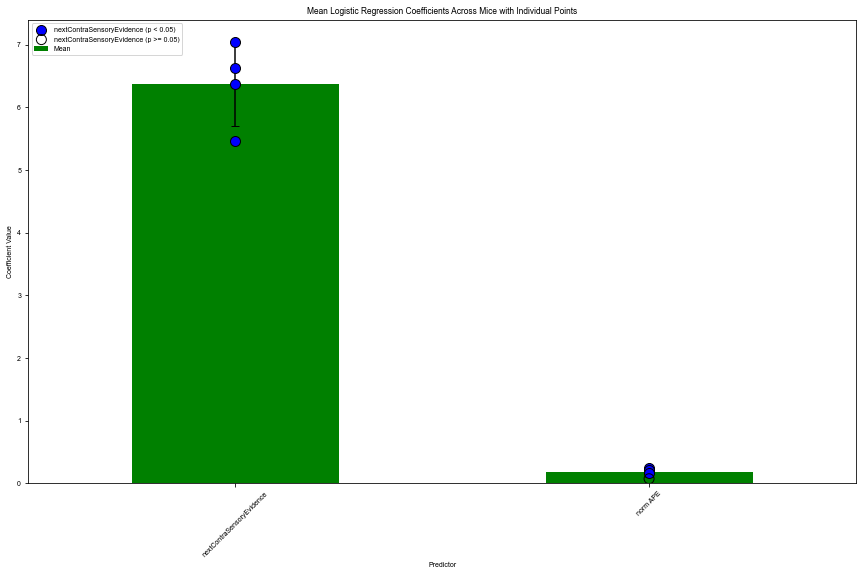

                               Mean       Std  t-Statistic   p-Value  \
nextContraSensoryEvidence  6.372620  0.668294    19.071305  0.000315   
norm APE                   0.171137  0.076116     4.496734  0.020530   

                           Significant  
nextContraSensoryEvidence         True  
norm APE                          True  


In [206]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Collect the coefficients and p-values into a DataFrame
coef_data = []

# Loop through each result and collect all regressors dynamically
for mouse, result in results.items():
    data = {'Mouse': mouse}
    
    # Loop through each parameter in the result (excluding the constant term)
    for param in result.params.index:
        if param != 'const':  # Skip the constant term
            data[param] = result.params[param]
            data[f'p_{param}'] = result.pvalues[param]
    
    coef_data.append(data)

# Convert to DataFrame
coef_df = pd.DataFrame(coef_data)

# Identify all regressors dynamically (excluding Mouse and p-values)
regressors = [col for col in coef_df.columns if col not in ['Mouse'] and not col.startswith('p_')]

# Calculate the mean and standard deviation across mice for numeric columns only
coef_mean = coef_df[regressors].mean()
coef_std = coef_df[regressors].std()

# Perform a one-sample t-test against zero for each coefficient across mice
t_stats, p_values = stats.ttest_1samp(coef_df[regressors], 0)

# Create a DataFrame to store the statistics
coef_stats = pd.DataFrame({
    'Mean': coef_mean,
    'Std': coef_std,
    't-Statistic': t_stats,
    'p-Value': p_values
})

# Determine significance (p < 0.05) at the group level
coef_stats['Significant'] = coef_stats['p-Value'] < 0.05

# Plotting the coefficients with error bars
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the means with error bars (standard deviations)
coef_stats['Mean'].plot(kind='bar', yerr=coef_stats['Std'], capsize=4, ax=ax, color=coef_stats['Significant'].map({True: 'green', False: 'red'}))

# Add scatter points for individual mice
for i, predictor in enumerate(regressors):
    x = np.full(len(coef_df), i)  # Position scatter points along x-axis
    
    # Determine if individual mouse coefficient is significant
    sig_mask = coef_df[f'p_{predictor}'] < 0.05
    
    # Plot filled scatter points for significant coefficients
    ax.scatter(x[sig_mask], coef_df[predictor][sig_mask], color='blue', edgecolor='black', s=100, zorder=3, label=f'{predictor} (p < 0.05)' if i == 0 else "")
    
    # Plot unfilled scatter points for non-significant coefficients
    ax.scatter(x[~sig_mask], coef_df[predictor][~sig_mask], facecolors='none', edgecolor='black', s=100, zorder=3, label=f'{predictor} (p >= 0.05)' if i == 0 else "")

# Customize the plot
plt.title('Mean Logistic Regression Coefficients Across Mice with Individual Points')
plt.ylabel('Coefficient Value')
plt.xlabel('Predictor')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

# Display the statistical significance table
print(coef_stats)


In [190]:
coef_df


,Mouse,nextContraSensoryEvidence,p_nextContraSensoryEvidence,norm APE,p_norm APE
0,SNL_photo21,6.626325,3.294641e-94,0.249967,0.000857
1,SNL_photo22,6.365866,5.289385e-93,0.203605,0.024749
2,SNL_photo26,5.460175,7.560926e-86,0.159756,0.005980
3,SNL_photo57,7.038115,7.603199e-104,0.071221,0.305669


In [ ]:
import seaborn as sns

# Resetting the index (if needed)
df = df.reset_index(drop=True).copy()
df['nextSideStay'] = (df['nextNumericSide'] == df['numericSide'])

# Loop over each unique value in the 'mouse' column
unique_mice = df['mouse'].unique()
# Create the new column 'staySensoryEvidence' with the transformation applied
df['nextStaySensoryEvidence'] = df['nextContraSensoryEvidence']

# Apply the transformation to the new column where df['numericSide'] == 0
df.loc[df['numericSide'] == 0, 'nextStaySensoryEvidence'] = 1 - df.loc[df['numericSide'] == 0, 'nextContraSensoryEvidence']

for mouse in unique_mice:
    # Subset the data for the current mouse
    df_subset = df[df['mouse'] == mouse].copy()
    df_subset = df_subset[df_subset['numericSide'] == 1]
    
    
    # Create the interaction term
    df_subset['Interaction'] = df_subset['norm APE'] * df_subset['nextStaySensoryEvidence']
    
    # Prepare the data for regression
    df_for_reg = df_subset[['norm APE', 'nextStaySensoryEvidence', 'Interaction', 'nextSideStay']].copy()
    #df_for_reg.loc[:, 'nextNumericSide'] = df_for_reg['nextSideStay'].astype(bool)
    # Convert boolean columns to categorical for hue
    df_for_plot = df_for_reg.copy()
    bool_columns = df_for_plot.select_dtypes(include=[bool]).columns
    df_for_plot[bool_columns] = df_for_plot[bool_columns].astype('category')

    # Pair plot with categorical hue (boolean variables)
    sns.pairplot(df_for_plot, hue=bool_columns[0], diag_kind='kde', markers=['o', 's'])
    plt.suptitle('Pair Plot with Categorical Variables', y=1.02)
    plt.show()
